In [18]:
import pandas as pd
from datetime import datetime
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from recommender.util import AmazonParser
from time import sleep
CSV_PATH='/Users/matejkvassay/project/data/book-recommender/ratings_Books.csv'
%matplotlib inline

### Reading and sorting data

In [5]:
raw_data=pd.read_csv(CSV_PATH,header=0,names=['user','item','rating','timestamp'])

### Dumping data < 2013.

In [6]:
raw_data=raw_data[raw_data['timestamp']>1356998400]

### Extract user-item impressions dict

In [7]:
def split(raw_data, quantile=0.8):
    q=raw_data['timestamp'].quantile(quantile)
    return raw_data[raw_data['timestamp']<=q], raw_data[raw_data['timestamp']>q]

def get_user_items_dict(data, min_ratings, max_ratings):
    user_item_dict=dict()
    for row in data.itertuples():
        if row.user in user_item_dict:
            user_item_dict[row.user].append(row.item)
        else:
            user_item_dict[row.user]=[row.item]
    user_item_dict_clean={key: value for key,value in user_item_dict.iteritems() if len(value)>=min_ratings and len(value)<max_ratings}
    return user_item_dict_clean

def get_user_items_list_lengths(user_item_dict):
    return pd.DataFrame(sorted([len(item_list) for _,item_list in user_item_dict.iteritems()]))
    

### Train-test split

In [8]:
raw_train, raw_test = split(raw_data)

In [9]:
user_item_train = get_user_items_dict(raw_train, min_ratings=3, max_ratings=100)
user_item_test = get_user_items_dict(raw_test, min_ratings=1, max_ratings=1000000)

### Training dataset Analysis

#### User count

In [10]:
len(user_item_train.keys())

757105

#### Item count distribution per user

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x171ec4610>]], dtype=object)

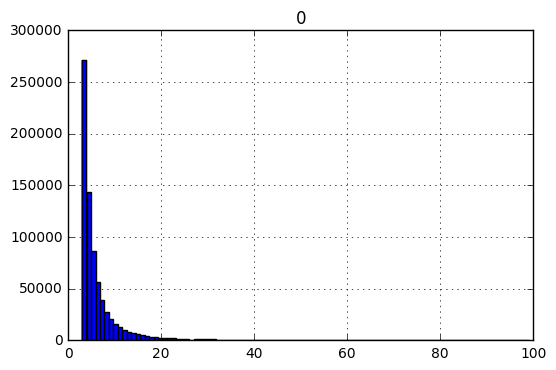

In [11]:
get_user_items_list_lengths(user_item_train).hist(bins=100)

### Training

In [12]:
train_data=[TaggedDocument(words, [user_id]) for user_id, words in user_item_train.iteritems()]

In [13]:
#doc2vec
model = Doc2Vec(train_data, dm=0,size=30, window=8, min_count=5, workers=4)

In [28]:
model.vocab

{'1594483752': <gensim.models.word2vec.Vocab at 0x14b4a9490>,
 '0062513958': <gensim.models.word2vec.Vocab at 0x1491b5450>,
 '1490405461': <gensim.models.word2vec.Vocab at 0x14f5fc710>,
 'B00GA664GC': <gensim.models.word2vec.Vocab at 0x147da2c50>,
 '0446601853': <gensim.models.word2vec.Vocab at 0x1496d27d0>,
 '0140431357': <gensim.models.word2vec.Vocab at 0x14e05fa10>,
 '0062024175': <gensim.models.word2vec.Vocab at 0x14c6a05d0>,
 'B00G7067FY': <gensim.models.word2vec.Vocab at 0x172a2c1d0>,
 'B00H9WCJR4': <gensim.models.word2vec.Vocab at 0x11171d950>,
 '0399250824': <gensim.models.word2vec.Vocab at 0x172a2c8d0>,
 'B00D72WW7W': <gensim.models.word2vec.Vocab at 0x14b4a94d0>,
 'B00G4DTCCY': <gensim.models.word2vec.Vocab at 0x14e05fa50>,
 'B00CCYWTEC': <gensim.models.word2vec.Vocab at 0x14e05fa90>,
 '1477694919': <gensim.models.word2vec.Vocab at 0x14908c650>,
 '1590770218': <gensim.models.word2vec.Vocab at 0x14b4a9510>,
 'B00HPMPJKW': <gensim.models.word2vec.Vocab at 0x14c00ced0>,
 '160061

In [29]:
similar_list=model.most_similar('147016891X')
asin_list=[item[0] for item in similar_list]
similar_list

[('0988904918', 0.7157068252563477),
 ('0694015822', 0.7032818794250488),
 ('0312997914', 0.6941559910774231),
 ('0385344201', 0.6940163373947144),
 ('1494407752', 0.6828104257583618),
 ('141696133X', 0.6824548840522766),
 ('0310723485', 0.6741974353790283),
 ('B005UHFFF8', 0.6609833836555481),
 ('B0083DHIOW', 0.6525143384933472),
 ('B007H7QTG8', 0.6520483493804932)]

### Visualization

In [40]:
def get_product_metadata(asin_list,sleep_s=5):
    extracted_data = dict()
    for asin in asin_list:
        url = "http://www.amazon.com/dp/"+asin
        extracted_data[asin]=AmazonParser(url)
        sleep(sleep_s)
    return extracted_data
    

In [41]:
similar_list=model.most_similar('B00H9WCJR4')
asin_list=[item[0] for item in similar_list]

metadata=get_product_metadata(asin_list)

In [42]:
similar_list

[('1569242739', 0.720393717288971),
 ('0486227316', 0.7143394947052002),
 ('054546756X', 0.7124874591827393),
 ('149522435X', 0.7087608575820923),
 ('B004JHYTV6', 0.6995528936386108),
 ('078683675X', 0.6963318586349487),
 ('B00DR72Y5C', 0.6871738433837891),
 ('0312961278', 0.6869434714317322),
 ('0891096582', 0.6746400594711304),
 ('B003CT39M2', 0.6739785671234131)]

In [43]:
{extracted['CATEGORY'] for extracted in metadata}

{'0312961278': {'AVAILABILITY': None,
  'CATEGORY': None,
  'NAME': None,
  'ORIGINAL_PRICE': None,
  'SALE_PRICE': None,
  'URL': 'http://www.amazon.com/dp/0312961278'},
 '0486227316': {'AVAILABILITY': None,
  'CATEGORY': None,
  'NAME': None,
  'ORIGINAL_PRICE': None,
  'SALE_PRICE': None,
  'URL': 'http://www.amazon.com/dp/0486227316'},
 '054546756X': {'AVAILABILITY': None,
  'CATEGORY': None,
  'NAME': None,
  'ORIGINAL_PRICE': None,
  'SALE_PRICE': None,
  'URL': 'http://www.amazon.com/dp/054546756X'},
 '078683675X': {'AVAILABILITY': None,
  'CATEGORY': None,
  'NAME': None,
  'ORIGINAL_PRICE': None,
  'SALE_PRICE': None,
  'URL': 'http://www.amazon.com/dp/078683675X'},
 '0891096582': {'AVAILABILITY': None,
  'CATEGORY': None,
  'NAME': None,
  'ORIGINAL_PRICE': None,
  'SALE_PRICE': None,
  'URL': 'http://www.amazon.com/dp/0891096582'},
 '149522435X': {'AVAILABILITY': None,
  'CATEGORY': None,
  'NAME': None,
  'ORIGINAL_PRICE': None,
  'SALE_PRICE': None,
  'URL': 'http://www.am